<a href="https://colab.research.google.com/github/DataBytes-Organisation/Fine-Tuning-LLMs-for-Enterprise-Applications/blob/ed_branch/Ed_LLM_FineTuning_PubMedQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personalized Healthcare QA System (Chatbot) - V3 - PubMedQA
#### Ed:215279167
---
### Objective:
Develop a healthcare chatbot that answers patient inquiries on medications, symptoms, and  treatments while reducing hallucinations.

### Update and changes:
This updated notebook reflects changes learned from weeks 1 -7 experiments with fine-tuning. Main changes include:
* Use single dataset of PubMedQA. Initial attempts to use a combination of MedDialog and PubMedQA didn't provide significant improvements in evaluation, and beleive this is due to differing data quality in MedDialog dataset.
* Significant increase of data used for fine-tuning

### Datasets:
* PubMedQA – Biomedical QA dataset - https://huggingface.co/datasets/qiaojin/PubMedQA

### Task Breakdown:
1. Train models on medical QA datasets.
2. Fine-tune for patient-friendly responses (simplified, clear language).
3. Ensure context-aware, regulatory-compliant answers:  
o Implement FDA/TGA guideline alignment.
o Develop a retrieval-based validation for generated answers.
4. Deploy as a chatbot interface (React-based UI + API integration).
5. Implement real-time fact-checking:  
o Confidence score visualization (green = high confidence, yellow = medium, red = low
confidence).
o Integration with PubMed and trusted medical sources.

### Models to Use:
• Llama-2 7B

### Evaluation Metrics:
* Rouge, BLEU, Meteor, BertScore, Manual inspection

---
## 1. Import libraries and model to prepare for fine tuning

In [ ]:
!pip install datasets requests bitsandbytes accelerate peft trl sentencepiece wandb transformers evaluate rouge_score bert-score

### IMPORTANT: Restart Colab runtime after PIP install!!!

## 2. Implement base model and imports
First step is to import all necessary libraries and implement base model, to validate it can generate a response from prompt.

In [ ]:
from google.colab import userdata
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    logging,
    pipeline
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model, TaskType
from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import torch
import wandb
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import evaluate
import numpy as np
from bert_score import BERTScorer

In [ ]:
model_name = "meta-llama/Llama-2-7b-chat-hf"
project_name = "ed_medical"
hf_username = "digitalblue"

In [ ]:
# log into hugging face and wandb
hf_token = userdata.get('HF_TOKEN')
login(hf_token)

wandb_api_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = "ed_medical"
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if True else "end"
os.environ["WANDB_WATCH"] = "gradients"

In [ ]:
# quantisation config to use less memory when loading model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config)

In [ ]:
memory = model.get_memory_footprint() / 1e6
print(f"Memory footprint: {memory:,.1f} MB")

In [ ]:
# model architecture
model

In [ ]:
# initialise tokenizer and pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful personalised medical assistant"},
    {"role": "user", "content": "How can I get rid of the flu?"}
  ]

In [ ]:
# verify base model generates response
inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
outputs = model.generate(inputs, max_new_tokens=250)
print(tokenizer.decode(outputs[0]))

## 3. Dataset analysis and preprocessing for Llama
The datasets need to be analysed and prepared for fine-tuning the model. This includes removing invalid data and formatting into the required format with special tokens the Llama 2 model requires. Dataset acquired from HuggingFace
* PubMedQA - https://huggingface.co/datasets/qiaojin/PubMedQA

In [ ]:
# format input from datasets into prompt format required by llama model
def format_llama_prompt(user_message, model_answer):
  prompt = '<s>[INST] ' # special token - commence instruct
  prompt += user_message.strip()
  prompt += ' [/INST] ' # special token - end instruct
  prompt += model_answer.strip()
  prompt += ' </s>'# special token - end
  return prompt

def format_llama_prompt_with_context(user_message, model_answer, context):
  prompt = '<s>[INST] Given this context: ' # special token - commence instruct
  prompt += context['contexts'][0].strip()
  prompt += ' Question: '
  prompt += user_message.strip()
  prompt += ' [/INST] ' # special token - end instruct
  prompt += model_answer.strip()
  prompt += ' </s>'# special token - end
  return prompt

In [ ]:
# load pub_med_qa dataset
#pub_med_qa = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_unlabeled/train-00000-of-00001.parquet")
pub_med_qa = load_dataset("qiaojin/PubMedQA", "pqa_artificial")

In [ ]:
pub_med_qa

In [ ]:
pub_med_qa['train'][0]

In [ ]:
# create list of formatted prompts
pub_med_qa_as_prompt = []
for item in pub_med_qa['train']:
  if item['final_decision'] == 'yes': # only get rows with yes decision
    #pub_med_qa_as_prompt.append(format_llama_prompt(item['question'], item['long_answer']))
    pub_med_qa_as_prompt.append(format_llama_prompt_with_context(item['question'], item['long_answer'], item['context']))


In [ ]:
print(len(pub_med_qa_as_prompt))
print(pub_med_qa_as_prompt[0])

In [ ]:
pub_med_qa_as_prompt[200]

In [ ]:
# collect all formatted data into one dataset
prompt_dataset = pub_med_qa_as_prompt # + med_dialog_hcm_as_prompt + med_dialog_ic_as_prompt
print(len(prompt_dataset))

In [ ]:
# shuffle the combined dataset to disperse the data
# random.seed(42)
# random.shuffle(prompt_dataset)

In [ ]:
len(prompt_dataset)

In [ ]:
# convert to huggingface dataset, create splits and push to hub
prompt_hf_dataset = Dataset.from_dict({"text": prompt_dataset})

In [ ]:
ds_train = prompt_hf_dataset.train_test_split(test_size=0.2, seed=42)

In [ ]:
ds_train

In [ ]:
ds_test = ds_train['test'].train_test_split(test_size=0.5, seed=42)
ds_test

In [ ]:
ds_splits = DatasetDict({
    'train': ds_train['train'],
    'validation': ds_test['train'],
    'test': ds_test['test']
})

In [ ]:
ds_splits

In [ ]:
# push to hugging face
ds_splits.push_to_hub(f"{hf_username}/{project_name}-pubmedqa-artifical-with-context", private=True)

## 4. Model Training Pipeline
The model training pipeline is setup for fine-tuning. During this process additional data processing was required to filter out data with execessive token length that would exhaust GPU resources.

Initially four variants(A,B,C,D) of the model were fine-tuned on combination dataset, however focus is now on model variant E. It maintains integration with HuggingFace and Weight and Bias platform so models and runs are saved for later retrieval.

The models were fine-tuned on the **train** set, and evaluated with **validation** set.
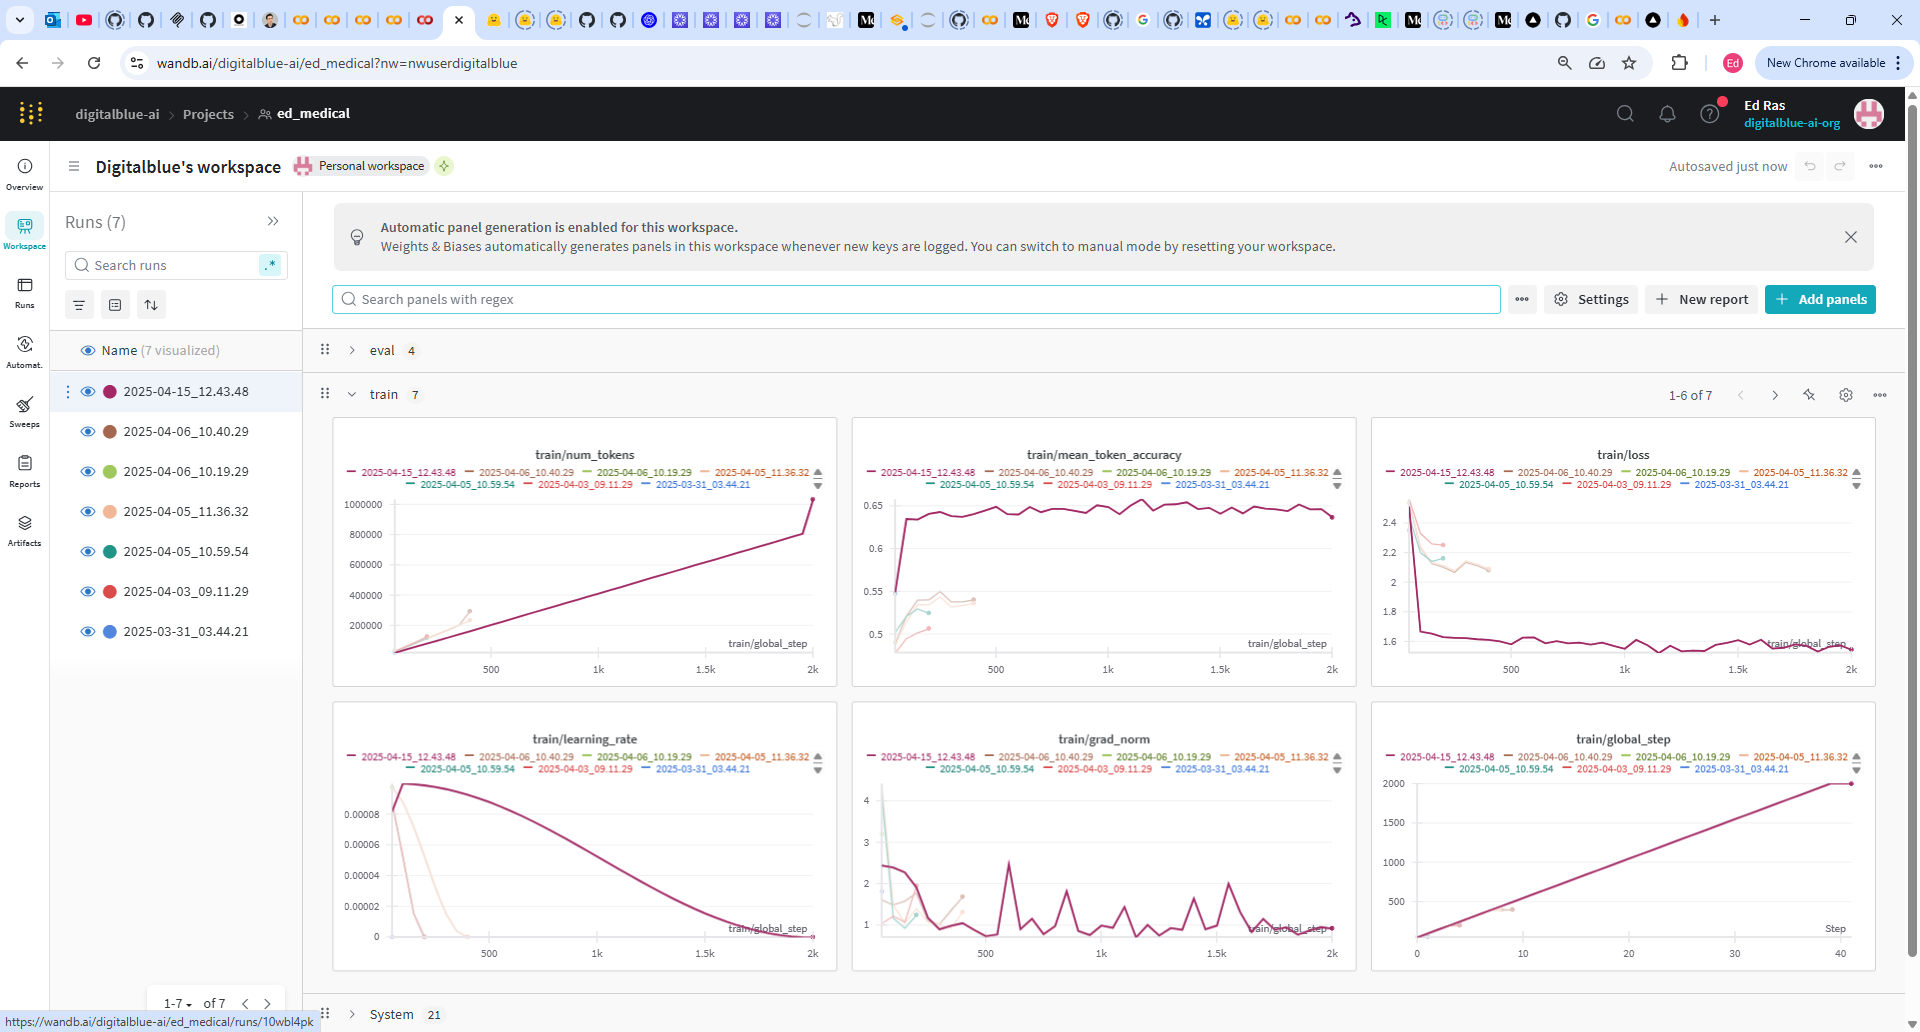

In [ ]:
# load pre-processed dataset created in last step from hugging face
#qa_dataset = load_dataset("digitalblue/ed_medical")
#qa_dataset = load_dataset("digitalblue/ed_medical-pubmedqa-artifical") # load only pubmedqa YES rows
qa_dataset = load_dataset("digitalblue/ed_medical-pubmedqa-artifical-with-context") # load only pubmedqa YES rows
qa_dataset

In [ ]:
# getting token lengths from training dataset
train_length = []
train_token_length = []
for item in qa_dataset['train']:
  if item['text']:
    train_length.append(len(item['text']))
    tokens = tokenizer.encode(item['text'])
    train_token_length.append(len(tokens))
  else:
    print(item)

In [ ]:
len(train_token_length)

In [ ]:
# print the min, max and average character lengths and token count lengths for training data
print(min(train_length), max(train_length), sum(train_length)/len(train_length))
print(min(train_token_length), max(train_token_length), sum(train_token_length)/len(train_token_length))

In [ ]:
# plot the token lengths
plt.figure(figsize=(15, 6))
plt.hist(train_token_length, rwidth=0.7, bins=100)
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.title('Token Length Distribution')
plt.show()

In [ ]:
# avg is now approx 104, but will keep 230 tokens, therefore will create new datasets
# to filter out any rows above this token count
MAX_TOKENS = 250
DATASET_SIZE = 1000
def get_filtered_dataset(dataset, max_tokens, size):
  count = 0
  train_size = round(size * 0.9) # 90% for train
  valid_size = round(size * 0.1) # 10% for eval
  print(f"Train size: {train_size}, Eval size: {valid_size}")

  filtered_train_dataset = []
  for item in dataset['train']:
    if item['text']:
      tokens = tokenizer.encode(item['text'])
      if len(tokens) < max_tokens:
        filtered_train_dataset.append(item)
        count += 1
      if count >= train_size:
        break

  count = 0
  filtered_eval_dataset = []
  for item in dataset['validation']:
    if item['text']:
      tokens = tokenizer.encode(item['text'])
      if len(tokens) < max_tokens:
        filtered_eval_dataset.append(item)

        count += 1
      if count >= valid_size:
        break

  return filtered_train_dataset, filtered_eval_dataset

In [ ]:
qa_train, qa_val = get_filtered_dataset(qa_dataset, MAX_TOKENS, DATASET_SIZE)
qa_train = Dataset.from_list(qa_train)
qa_val = Dataset.from_list(qa_val)
print(qa_train)
print(qa_val)

In [ ]:
qa_val[10]

In [ ]:
# set constants
MAX_SEQUENCE_LENGTH = 230 # calculated from avg token lenght in dataset

# Run name for saving the model in the hub
RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{project_name}-{RUN_NAME}"
HUB_MODEL_NAME = f"{hf_username}/{PROJECT_RUN_NAME}"

# qlora hyper params
LORA_R = 16 # Reduce LoRA rank (lower = less memory) , initial = 32
LORA_ALPHA = 32 # Lower alpha , initial = 64
TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj"]
LORA_DROPOUT = 0.05
QUANT_4_BIT = True

# training hyper params
EPOCHS = 3
BATCH_SIZE = 4  # Reduce batch size , initial = 4
GRADIENT_ACCUMULATION_STEPS = 8  # Simulate batch size 8, initial = 1
LEARNING_RATE = 2e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"
STEPS = 50
SAVE_STEPS = 2000
LOG_TO_WANDB = True

In [ ]:
response_template = " [/INST] "
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [ ]:
lora_params = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
training_params = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    #eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if True else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
    #neftune_noise_alpha=5 # using NEFTune as describe in SFT Trainer docs for increased conversational quality
)

In [ ]:
!nvidia-smi

In [ ]:
# clear gpu memory
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

In [ ]:
# Prepare the model for k-bit training (important for 4-bit)
model = prepare_model_for_kbit_training(model)

In [ ]:
model = get_peft_model(model, lora_params)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=qa_train,
    eval_dataset=qa_val,
    peft_config=lora_params,
    args=training_params
)


In [ ]:
#torch.cuda.empty_cache()
trainer.train()
trainer.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Model saved to HuggingFace as: {PROJECT_RUN_NAME}")
model.save_pretrained(PROJECT_RUN_NAME)


In [ ]:
results = trainer.evaluate()
print(results)


In [ ]:
wandb.finish()

In [ ]:
!zip -r ed_medical-2025-05-11_04.05.52.zip ed_medical-2025-05-11_04.05.52

In [ ]:
!ls -la

In [ ]:
!cp ed_medical-2025-05-11_04.05.52.zip /content/drive/MyDrive/

In [ ]:
# stop notebook and disconnect GPU after finishing above steps as this process can take several hours
# from google.colab import runtime
# runtime.unassign()

## 5. Evaluate the models - generate evaluation data
At this step the fine-tuned model created in the previous step can be re-loaded without need to re-run step 4. Generated responses will be collected, in addition to the base model to use as a benchmark.

The prompts to generate the responses are 50 samples from the **test** set, which was not used for fine-tuning.

The generated response for each model are then saved to HuggingFace hub for later analysis.

In [ ]:
# define models saved to huggingface hub from previous step
MODEL_A = "digitalblue/ed_medical-2025-04-03_09.11.29" # trained on 200 rows
MODEL_B = "digitalblue/ed_medical-2025-04-05_10.59.54" # trained on 800 rows
MODEL_C = "digitalblue/ed_medical-2025-04-05_11.36.32" # trained on 1600 rows
MODEL_D = "digitalblue/ed_medical-2025-04-06_10.40.29" # trained on 1600 rows with NEFTune
MODEL_E = "digitalblue/ed_medical-2025-04-15_12.43.48" # trained on 8000 rows of pubmedqa only w/ NEFTune
MODEL_F = "digitalblue/ed_medical-2025-05-05_23.51.25" # trained on 9000 row, lower learing rate, 3 epochs
MODEL_G = "digitalblue/ed_medical-2025-05-08_01.23.37" # trained on 9000 rows, NEFTune false
MODEL_H = "digitalblue/ed_medical-2025-05-11_04.05.52" # trained on 900 row, with context, 3 epochs

In [ ]:
# NOTE: Only using model E, F, G, H

In [ ]:
# quantisation config to use less memory when loading model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [ ]:
model_base = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto")

In [ ]:
# initialise tokenizer and pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
#qa_test = load_dataset("digitalblue/ed_medical", split="test[:50]") # first 50 from test set
qa_test = load_dataset("digitalblue/ed_medical-pubmedqa-artifical", split="test[:50]") # load only pubmedqa YES rows, test set

In [ ]:
# split into question and answer list
qa_list = []
for item in qa_test:
  prompt = item['text']
  question = re.search(r'\[INST\] (.*) \[/INST\]', prompt).group(1)
  response = re.search(r'\[/INST\] (.*) \</s\>', prompt).group(1)
  qa_list.append([question, response])

In [ ]:
qa_list[20][0] # question

In [ ]:
prompt1 = "You are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise."
#prompt2 = "You are a helpful personalised medical assistant. Provide a friendly personal response to the patients medical question within a paragraph, provide the necessary details. Follow up it they need more information"

def get_model_responses(model_x, qa_list):
  model_responses = []
  for item in qa_list:
    question = item[0]
    # print(item)
    # print(question)
    # print("-----")
    messages = [
      {"role": "system", "content": prompt1},
      {"role": "user", "content": question}
    ]
    inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
    outputs = model_x.generate(inputs, max_new_tokens=250, temperature=0.1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    answer = response.split('[/INST] ')[1]  # get text after /INST token
    answer = answer.replace('</s>', '') # remove trailing special token if present
    model_responses.append(answer)
  return model_responses

In [ ]:
print(model_base.lm_head.weight[0, :10])
print(model_g.lm_head.weight[0, :10])

In [ ]:
model_base_responses_pubmedqa = get_model_responses(model_base, qa_list)

In [ ]:
prompt_base_pubmedqa_dataset = Dataset.from_dict({"text": model_base_responses_pubmedqa})

In [ ]:
prompt_base_pubmedqa_dataset.push_to_hub(f"{hf_username}/model_base_responses_pubmedqa", private=True)

In [ ]:
prompt_base_pubmedqa_dataset[1]

In [ ]:
model_e = PeftModel.from_pretrained(model_base, MODEL_E)
model_f = PeftModel.from_pretrained(model_base, MODEL_F)

In [ ]:
model_e_responses = get_model_responses(model_e, qa_list)

In [ ]:
model_f_responses = get_model_responses(model_f, qa_list)

In [ ]:
prompt_e_dataset = Dataset.from_dict({"text": model_e_responses})
prompt_f_dataset = Dataset.from_dict({"text": model_f_responses})

In [ ]:
prompt_e_dataset.push_to_hub(f"{hf_username}/model_e_responses", private=True)
prompt_f_dataset.push_to_hub(f"{hf_username}/model_f_responses", private=True)

In [ ]:
model_g = PeftModel.from_pretrained(model_base, MODEL_G)

In [ ]:
model_g_responses = get_model_responses(model_g, qa_list)
prompt_g_dataset = Dataset.from_dict({"text": model_g_responses})
prompt_g_dataset.push_to_hub(f"{hf_username}/model_g_responses", private=True)

In [ ]:
model_h = PeftModel.from_pretrained(model_base, MODEL_H)
model_h_responses = get_model_responses(model_h, qa_list)
prompt_h_dataset = Dataset.from_dict({"text": model_h_responses})
prompt_h_dataset.push_to_hub(f"{hf_username}/model_h_responses", private=True)

In [ ]:
# stop notebook and disconnect GPU after finishing above steps as this process can take several hours
from google.colab import runtime
runtime.unassign()

## 6. Evaluate fine tuned models - get metrics from generated responses
In this final step, the generated response can be reloaded from HuggingFace to evaluate and calculate metrics against the expected responses in **test** dataset.

In [ ]:
qa_test = load_dataset("digitalblue/ed_medical-pubmedqa-artifical", split="test[:50]") # load only pubmedqa YES rows, test set

In [ ]:
qa_list = []
for item in qa_test:
  prompt = item['text']
  question = re.search(r'\[INST\] (.*) \[/INST\]', prompt).group(1)
  response = re.search(r'\[/INST\] (.*) \</s\>', prompt).group(1)
  qa_list.append([question, response])

In [ ]:
qa_list[20][1] # index 1 is dataset real response

In [ ]:
qa_references = [item[1] for item in qa_list] # get list of reference responses

In [ ]:
# load saved response data to evaluate
model_base_pubmedqa_dataset = load_dataset("digitalblue/model_base_responses_pubmedqa")
model_e_dataset = load_dataset("digitalblue/model_e_responses")
model_f_dataset = load_dataset("digitalblue/model_f_responses")
model_g_dataset = load_dataset("digitalblue/model_g_responses")
model_h_dataset = load_dataset("digitalblue/model_h_responses")

In [ ]:
# convert to list
base_pubmedqa_response_list = model_base_pubmedqa_dataset['train']['text'][:50]
e_response_list = model_e_dataset['train']['text'][:50]
f_response_list = model_f_dataset['train']['text'][:50]
g_response_list = model_g_dataset['train']['text']
h_response_list = model_h_dataset['train']['text']

In [ ]:
def calc_rouge_metric(references, predictions):
  rouge = evaluate.load('rouge')
  results = rouge.compute(
    predictions=predictions,
    references=references
  )
  return results

def calc_bleu_metric(references, predictions):
  bleu = evaluate.load('bleu')
  results = bleu.compute(
    predictions=predictions,
    references=references
  )
  return results

def calc_meteor_metric(references, predictions):
  meteor = evaluate.load('meteor')
  results = meteor.compute(
    predictions=predictions,
    references=[[ref] for ref in references]
  )
  return results

def calc_bert_score(references, predictions):
  bert_scorer = BERTScorer(model_type='bert-base-uncased')
  P = []
  R = []
  F1 = []

  for i in range(len(predictions)):
    p_i, r_i, f1_i = bert_scorer.score([predictions[i]], [references[i]])
    P.append(p_i)
    R.append(r_i)
    F1.append(f1_i)
  results = {
    'P': np.mean(P),
    'R': np.mean(R),
    'F1': np.mean(F1)
  }
  return results

In [ ]:
rouge_base_pubmedqa = calc_rouge_metric(qa_references, base_pubmedqa_response_list)
rouge_e = calc_rouge_metric(qa_references, e_response_list)
rouge_f = calc_rouge_metric(qa_references, f_response_list)
rouge_g = calc_rouge_metric(qa_references, g_response_list)
rouge_h = calc_rouge_metric(qa_references, h_response_list)

In [ ]:
print(rouge_base_pubmedqa)
print(rouge_e)
print(rouge_f)
print(rouge_g)
print(rouge_h)

In [ ]:
# plot rouge scores
rouge_dict = {
    'rouge1': (rouge_base_pubmedqa['rouge1'], rouge_e['rouge1'], rouge_f['rouge1'], rouge_g['rouge1'], rouge_h['rouge1']),
    'rouge2': (rouge_base_pubmedqa['rouge2'], rouge_e['rouge2'], rouge_f['rouge2'], rouge_g['rouge2'], rouge_h['rouge2']),
    'rougeL': (rouge_base_pubmedqa['rougeL'], rouge_e['rougeL'], rouge_f['rougeL'], rouge_g['rougeL'], rouge_h['rougeL']),
    'rougeLsum': (rouge_base_pubmedqa['rougeLsum'], rouge_e['rougeLsum'], rouge_f['rougeLsum'], rouge_g['rougeLsum'], rouge_h['rougeLsum'])
}
model_labels = ('Base', 'Model E', 'Model F', 'Model G', 'Model H')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in rouge_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Rouge Score')
ax.set_title('Rouge Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [ ]:
bleu_base_pubmedqa = calc_bleu_metric(qa_references, base_pubmedqa_response_list)
bleu_e = calc_bleu_metric(qa_references, e_response_list)
bleu_f = calc_bleu_metric(qa_references, f_response_list)
bleu_g = calc_bleu_metric(qa_references, g_response_list)
bleu_h = calc_bleu_metric(qa_references, h_response_list)

In [ ]:
print(bleu_base_pubmedqa)
print(bleu_e)
print(bleu_f)
print(bleu_g)
print(bleu_h)

In [ ]:
# plot bleu scores
bleu_dict = {
    'bleu': (bleu_base_pubmedqa['bleu'], bleu_e['bleu'], bleu_f['bleu'], bleu_g['bleu'], bleu_h['bleu']),
    'brevity_penalty': (bleu_base_pubmedqa['brevity_penalty'], bleu_e['brevity_penalty'], bleu_f['brevity_penalty'], bleu_g['brevity_penalty'], bleu_h['brevity_penalty'])
}

model_labels = ('Base', 'Model E', 'Model F', 'Model G', 'Model H')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bleu_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Bleu Score')
ax.set_title('Bleu Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [ ]:
meteor_base_pubmedqa = calc_meteor_metric(qa_references, base_pubmedqa_response_list)
meteor_e = calc_meteor_metric(qa_references, e_response_list)
meteor_f = calc_meteor_metric(qa_references, f_response_list)
meteor_g = calc_meteor_metric(qa_references, g_response_list)
meteor_h = calc_meteor_metric(qa_references, h_response_list)

In [ ]:
print(meteor_base_pubmedqa)
print(meteor_e)
print(meteor_f)
print(meteor_g)
print(meteor_h)

In [ ]:
# plot meteor scores
meteor_dict = {
    'meteor': (meteor_base_pubmedqa['meteor'], meteor_e['meteor'], meteor_f['meteor'], meteor_g['meteor'], meteor_h['meteor'])
}
model_labels = ('Base', 'Model E', 'Model F', 'Model G', 'Model H')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in meteor_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Meteor Score')
ax.set_title('Meteor Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [ ]:
bert_score_base_pubmedqa = calc_bert_score(qa_references, base_pubmedqa_response_list)
bert_score_e = calc_bert_score(qa_references, e_response_list)
bert_score_f = calc_bert_score(qa_references, f_response_list)
bert_score_g = calc_bert_score(qa_references, g_response_list)
bert_score_h = calc_bert_score(qa_references, h_response_list)

In [ ]:
print(bert_score_base_pubmedqa)
print(bert_score_e)
print(bert_score_f)
print(bert_score_g)
print(bert_score_h)

In [ ]:
# plot bert scores
bert_score_dict = {
    'P': (bert_score_base_pubmedqa['P'], bert_score_e['P'], bert_score_f['P'], bert_score_g['P'], bert_score_h['P']),
    'R': (bert_score_base_pubmedqa['R'], bert_score_e['R'], bert_score_f['R'], bert_score_g['R'], bert_score_h['R']),
    'F1': (bert_score_base_pubmedqa['F1'], bert_score_e['F1'], bert_score_f['F1'], bert_score_g['F1'], bert_score_h['F1'])
}
model_labels = ('Base', 'Model E', 'Model F', 'Model G', 'Model H')

x = np.arange(len(model_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in bert_score_dict.items():
    offset = width * multiplier
    msr = np.round(measurement, 4) # round to 4 decimal places for plot
    rects = ax.bar(x + offset, msr, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

ax.set_ylabel('Bert Score')
ax.set_title('Bert Score Comparison')
ax.set_xticks(x + width, model_labels)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1)

plt.show()

In [ ]:
# human evaluation
def print_response(QA_NUM):
  for i in range(QA_NUM):
    print('-----------------------------------------')
    print('\nTest question: ' + qa_list[i][0])
    print('\nTest answer: ' + qa_list[i][1])
    print('\nBase: ' + base_pubmedqa_response_list[i])
    print('\nModel E: ' + e_response_list[i])
    print('\nModel F: ' + f_response_list[i])
    print('\nModel G: ' + g_response_list[i])
    print('\nModel H: ' + h_response_list[i])

print_response(5)

## 7. Evaluation Summary
Evaluation metrics do not show improvement over base model. The Llama 2 model does not disclose its training dataset, however as PubMedQA is public data, there exists the possiblity that it may have already been trained on this dataset.

Alternatively, the training hyperparameters used in training and/or the volume of data used may have been insufficinet for the model to successfully learn the domain.

Next steps:
* Continue to experiment with further hyperparameter tuning
* Increase volume of training data
* Adjust system prompt, and model parameters on inference
* Explore different dataset



---



## 8. Model packaging
This sections explored how to bundle the fine-tuned model with adapters and  including tokenizer, into an LLM that can be downloaded and used standalone. The intention was to investigate how it could be deployed to a cloud provider, and used on edge device or local PC via Ollama.

In [ ]:
# clear gpu memory
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

In [ ]:
# quantisation config to use less memory when loading model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    #quantization_config=quant_config,
    device_map="auto"
    )

In [ ]:
# initialise tokenizer and pipeline
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
MODEL_A = "digitalblue/ed_medical-2025-04-03_09.11.29" # trained on 200 rows
MODEL_B = "digitalblue/ed_medical-2025-04-05_10.59.54" # trained on 800 rows
MODEL_C = "digitalblue/ed_medical-2025-04-05_11.36.32" # trained on 1600 rows
MODEL_D = "digitalblue/ed_medical-2025-04-06_10.40.29" # trained on 1600 rows with NEFTune
MODEL_E = "digitalblue/ed_medical-2025-04-15_12.43.48" # trained on 8000 rows of pubmedqa only w/ NEFTune
MODEL_F = "digitalblue/ed_medical-2025-05-05_23.51.25" # trained on 9000 row, lower learing rate, 3 epochs

In [ ]:
model_e = PeftModel.from_pretrained(model, MODEL_E)

In [ ]:
print(model.lm_head.weight[0, :10])
print(model_e.lm_head.weight[0, :10])
print(model_f.lm_head.weight[0, :10])

In [ ]:
model_e.print_trainable_parameters()
model_f.print_trainable_parameters()

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise."},
    {"role": "user", "content": "Does methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies?"}
]

In [ ]:
og_output = model_e.generate(tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda"), max_new_tokens=250)

In [ ]:
tokenizer.decode(og_output[0], skip_special_tokens=False)

In [ ]:
base_output = model.generate(tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda"), max_new_tokens=250)
tokenizer.decode(base_output[0], skip_special_tokens=False)

In [ ]:
merge_model_e = model_e.merge_and_unload()

In [ ]:
merge_model_f = model_f.merge_and_unload()

In [ ]:
merge_model_f

In [ ]:
save_folder = "digitalblue/model_e_merge_v2"

In [ ]:
merge_model_e.save_pretrained(save_folder, safe_serialization=True)

In [ ]:
tokenizer.save_pretrained(save_folder)

In [ ]:
from huggingface_hub import create_repo

repo_id = "digitalblue/model_e_merge_v2"
create_repo(repo_id, repo_type="model", exist_ok=True, private=True)

In [ ]:
merge_model_e.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

In [ ]:
save_folder = "digitalblue/model_f_merge"
merge_model_f.save_pretrained(save_folder, safe_serialization=True)
tokenizer.save_pretrained(save_folder)

repo_id = save_folder
create_repo(repo_id, repo_type="model", exist_ok=True, private=True)

merge_model_f.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

messages = [
    {"role": "user", "content": "Does methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies?"},
]
pipe = pipeline("text-generation", model="digitalblue/model_e_merge_v2")
pipe(messages)

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful personalised medical assistant. In your response do not include any personal names and keep your answer professional and concise."},
    {"role": "user", "content": "Does methylphenidate improve the quality of life of children and adolescents with ADHD and difficult-to-treat epilepsies?"}
]
pipe(messages)

## Print to PDF

In [ ]:
#install necessary packages for printing to pdf
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install nbconvert

In [ ]:
#Convert your notebook into PDF
!jupyter nbconvert --to pdf '/content/drive/My Drive/Colab Notebooks/Ed LLM FineTuning_PubMedQA.ipynb'